In [3]:
import torch, numpy as np, cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import open3d as o3d

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("torch:", torch.__version__, "cuda available:", torch.cuda.is_available())
print("numpy:", np.__version__)
print("cv2:", cv2.__version__)

model = YOLO("yolov8n.pt")
print("YOLOv8 model loaded:", type(model))

torch: 2.2.2 cuda available: False
numpy: 1.26.4
cv2: 4.11.0
YOLOv8 model loaded: <class 'ultralytics.models.yolo.model.YOLO'>


In [2]:
rgb_video = './images/WhiteBackgroundSept27/take_6/rgb.avi'
depth_video = './images/WhiteBackgroundSept27/take_6/depth.avi'
depth_file = './images/WhiteBackgroundSept27/take_6/depth_raw.npy'

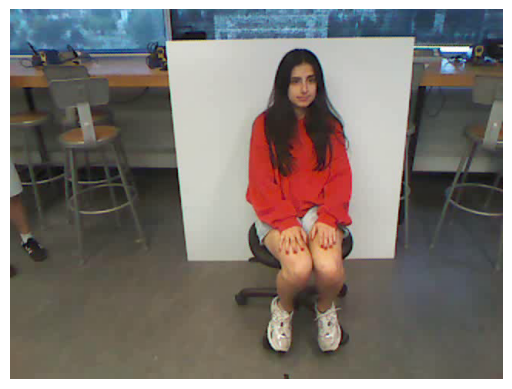

In [3]:
output_rgb_image_path = "rgb_img.png"
cap = cv2.VideoCapture(rgb_video)
ret, frame_rgb = cap.read()

if ret:
    cv2.imwrite(output_rgb_image_path, frame_rgb)
    frame_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()
else:
    print("Failed to read video")

cap.release()

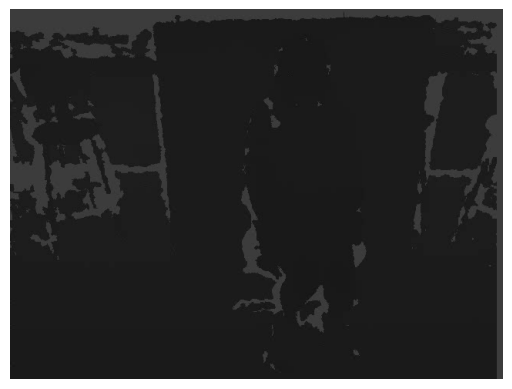

In [4]:
output_depth_image_path = "depth_img.png"
cap = cv2.VideoCapture(depth_video)
ret, frame_depth = cap.read()

if ret:
    cv2.imwrite(output_depth_image_path, frame_depth)
    frame_depth = cv2.cvtColor(frame_depth, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_depth)
    plt.axis("off")
    plt.show()
else:
    print("Failed to read video")

cap.release()

In [22]:
depth_data = np.load("./images/sub-003/depth_raw_2.npy")
print("Depth data shape:", depth_data.shape)

# extract the first frame's depth map
depth_notnormalized = depth_data[0]

depth_normalized = cv2.normalize(depth_notnormalized, None, 0, 255, cv2.NORM_MINMAX)
depth_normalized = depth_normalized.astype(np.uint8)

cv2.imwrite("first_depth_frame_out4.png", depth_normalized)
print("First depth frame saved as first_depth_frame.png")

Depth data shape: (480, 640)
First depth frame saved as first_depth_frame.png


In [4]:
frame_rgb = "./images/sub-004/rgb_2.png"
# depth_notnormalized = "./images/sub-003/depth_2.png"

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/ipykernel_4892/1047381378.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for b in preds.boxes if int(b.cls.cpu().numpy()) == 0]
/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/ipykernel_4892/1047381378.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(b.conf.cpu().numpy()))


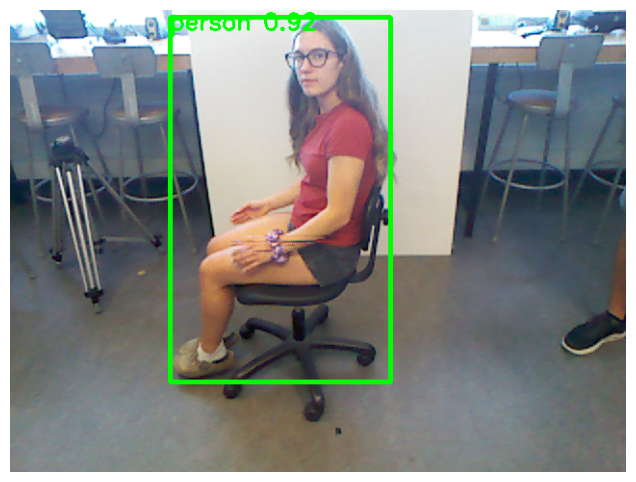

In [5]:

frame_rgb = cv2.imread(frame_rgb)

# make sure image was loaded
if frame_rgb is None:
    raise FileNotFoundError("Image not found or cannot be opened.")

# convert from BGR (OpenCV default) to RGB (for plotting and model)
img_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB)
H, W = frame_rgb.shape[:2]

# --- run prediction ---
preds = model.predict(source=frame_rgb, imgsz=640, conf=0.3, verbose=False)[0]

# read image
img_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB)
H, W = frame_rgb.shape[:2]

# predict
preds = model.predict(source=frame_rgb, imgsz=640, conf=0.3, verbose=False)[0]

# get person boxes (COCO class 0)
person_boxes = [(int(b.xyxy[0][0]), int(b.xyxy[0][1]),
                 int(b.xyxy[0][2]), int(b.xyxy[0][3]),
                 float(b.conf.cpu().numpy()))
                for b in preds.boxes if int(b.cls.cpu().numpy()) == 0]

if not person_boxes:
    raise RuntimeError("No person detected!")

# pick highest-confidence person
x1, y1, x2, y2, conf = max(person_boxes, key=lambda b: b[4])

# draw bbox on image
img_bbox = img_rgb.copy()
cv2.rectangle(img_bbox, (x1, y1), (x2, y2), (0, 255, 0), 3)
cv2.putText(img_bbox, f"person {conf:.2f}", (x1, max(20, y1-6)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# display
plt.figure(figsize=(8,6))
plt.imshow(img_bbox)
plt.axis('off')
plt.show()

In [5]:
!wget -O sam_vit_h.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
SAM_CHECKPOINT = './sam_vit_h.pth'

--2025-10-17 10:31:49--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.118, 3.171.22.33, 3.171.22.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h.pth’

sam_vit_h.pth       100%[===================>]   2.39G  15.4MB/s    in 2m 36s  

2025-10-17 10:34:26 (15.6 MB/s) - ‘sam_vit_h.pth’ saved [2564550879/2564550879]



In [6]:
# Install SAM from GitHub
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/pip-req-build-f5ank6qb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/k9/q0p5_p4s46q2lxnn596xb31h0000gn/T/pip-req-build-f5ank6qb
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


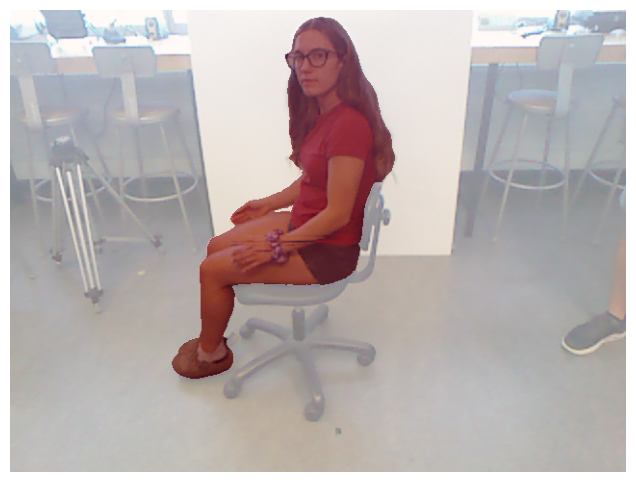

In [6]:
# path to checkpoint downloaded above
from segment_anything import SamPredictor, sam_model_registry
SAM_CHECKPOINT = './sam_vit_h.pth'
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(DEVICE)

# SAM predictor
predictor = SamPredictor(sam)

# image from yolo
predictor.set_image(img_rgb)

# use the bounding box prediction from YOLO as the input for SAM
box = np.array([x1, y1, x2, y2]) 

# only output 1 mask per bounding box
masks, scores, logits = predictor.predict(box=box[None, :], multimask_output=False)

# final mask
person_mask = masks[0]

# visualize overlayed mask on image
plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
plt.imshow(person_mask, alpha=0.5, cmap='Reds')
plt.axis('off')
plt.show()

Masked depth count: 32867
min: 825.0
max: 2047.0
mean: 876.6053792557885
median: 858.0


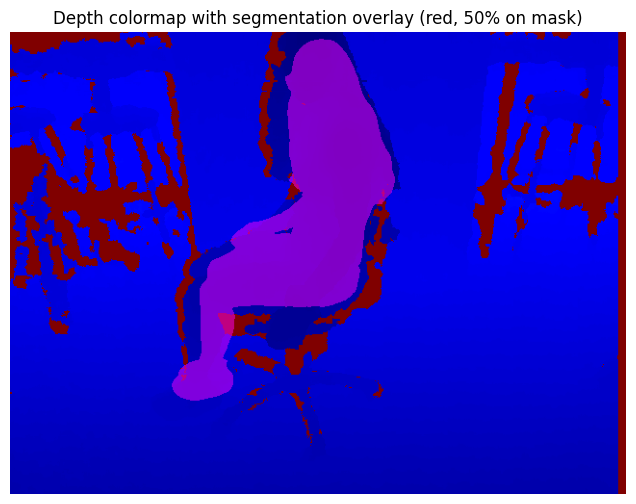

Saved rgb_person_only_oct4_4.png


In [8]:
depth_notnormalized =  np.load("./images/sub-004/depth_raw_2.npy")
# depth_notnormalized = cv2.imread(depth_notnormalized, cv2.IMREAD_UNCHANGED)

# ensure mask is boolean
mask = person_mask.astype(bool)

# get shape of both images
H_mask, W_mask = mask.shape
H_depth, W_depth = depth_notnormalized.shape

# extract depth values inside the mask
# 1D array of depth values within mask - used to compute metrics
masked_depth_values = depth_notnormalized[mask]
print("Masked depth count:", masked_depth_values.size)

# compute basic depth metrics inside the mask for verification
# assuming this is in mm
if masked_depth_values.size > 0:
    print("min:", float(np.nanmin(masked_depth_values)))
    print("max:", float(np.nanmax(masked_depth_values)))
    print("mean:", float(np.nanmean(masked_depth_values)))
    print("median:", float(np.nanmedian(masked_depth_values)))
else:
    print("Mask contains no pixels (empty).")

# create a map where everything not in the mask is nan
masked_depth_map = np.full_like(depth_notnormalized, np.nan, dtype=np.float32)
masked_depth_map[mask] = depth_notnormalized[mask]

# save raw masked values (1D) 
np.save("person_depth_values_oct4_4.npy", masked_depth_values) 

# contains nan (2D)
np.save( "person_depth_map_oct4_4.npy", masked_depth_map)

# colorize full depth and overlay the segmentation outline / fill
# Normalize full depth for display
depth_vis = depth_notnormalized.copy().astype(np.float32)

# handle constant depth case
if np.nanmax(depth_vis) - np.nanmin(depth_vis) <= 0:
    # constant depth everwhere
    print("constant depth values found")
    depth_norm = np.zeros_like(depth_vis, dtype=np.uint8)
else:
    # normalizing the depth
    depth_norm = cv2.normalize(depth_vis, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

depth_colormap = cv2.applyColorMap(depth_norm, cv2.COLORMAP_JET)

# create colored mask overlay - purpleish
overlay_color = np.zeros_like(depth_colormap)
overlay_color[mask] = (255, 0, 255)                     
alpha = 0.5                                         

# blend only where mask is true
blended = depth_colormap.copy()
blended[mask] = cv2.addWeighted(depth_colormap[mask], 1 - alpha, overlay_color[mask], alpha, 0)

# convert BGR -> RGB for matplotlib
blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

# display
plt.figure(figsize=(8, 6))
plt.imshow(blended_rgb)
plt.axis('off')
plt.title("Depth colormap with segmentation overlay (red, 50% on mask)")
plt.show()

# save depth overlay image
cv2.imwrite("depth_with_mask_overlay_oct4_4.png", blended)

rgb_person_only = img_rgb.copy()
rgb_person_only[~mask] = 0
cv2.imwrite("rgb_person_only_oct4_4.png", cv2.cvtColor(rgb_person_only, cv2.COLOR_RGB2BGR))
print("Saved rgb_person_only_oct4_4.png")

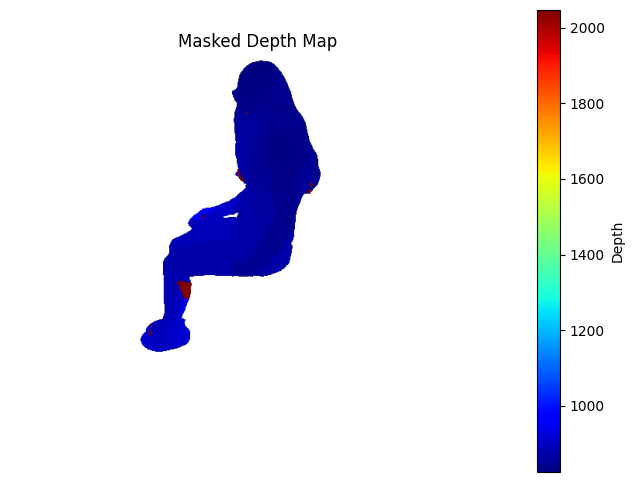

In [9]:

# view depth npy values
masked_depth_map = np.load("person_depth_map_oct4_4.npy")

plt.figure(figsize=(8,6))
plt.imshow(masked_depth_map, cmap="jet")
plt.colorbar(label="Depth")
plt.axis("off")
plt.title("Masked Depth Map")
plt.savefig("person_depth_map_plot_oct4_4.png", bbox_inches='tight', dpi=300)
plt.show()



In [10]:
import numpy as np
import open3d as o3d

# load depth map and masked values
depth_map = np.load("person_depth_map_oct4_4.npy")
masked_depth_values = np.load("person_depth_values_oct4_4.npy")
depth_map = np.nan_to_num(depth_map, nan=0.0)
H, W = depth_map.shape

# generate pixel grid
u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)
u = u.flatten()
v = v.flatten()
z = depth_map.flatten()

# keep valid points within depth percentiles
valid = z > 0

v_flipped = H - 1 - v[valid]
points = np.stack([u[valid], v_flipped, z[valid]], axis=-1)

# create point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# remove small floating blobs using DBSCAN
labels = np.array(pcd.cluster_dbscan(eps=10.0, min_points=50))

# keep only the largest cluster
largest_label = np.bincount(labels[labels >= 0]).argmax()
pcd_mainbody = pcd.select_by_index(np.where(labels == largest_label)[0])

# visualize and save
o3d.visualization.draw_geometries([pcd_mainbody])
o3d.io.write_point_cloud("person_point_cloud_mainbody_oct4_4.ply", pcd_mainbody)


True

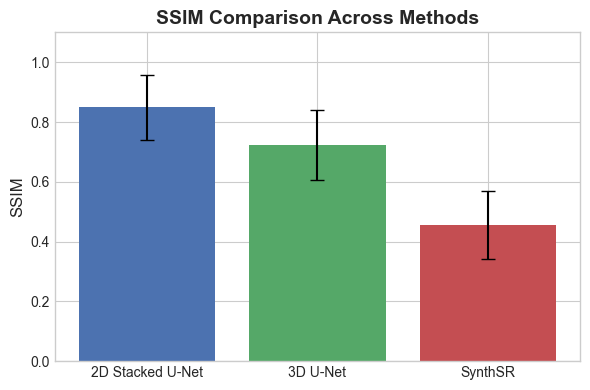

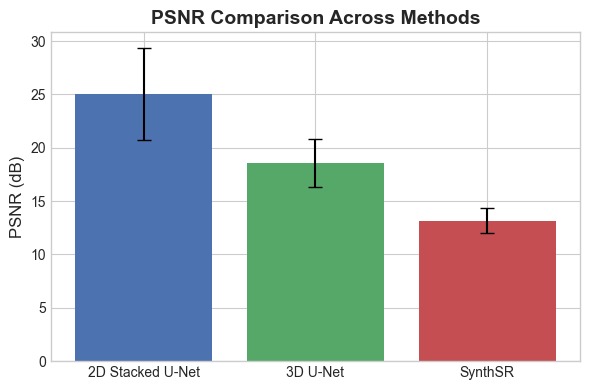

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Methods
methods = ['2D Stacked U-Net', '3D U-Net', 'SynthSR']

# ---- SSIM ----
ssim_means = [0.8495, 0.7233, 0.4544]
ssim_stds = [0.1084, 0.1159, 0.1142]

# ---- PSNR ----
psnr_means = [25.07, 18.61, 13.18]
psnr_stds = [4.29, 2.26, 1.15]

# ---- Plot Style ----
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#4C72B0', '#55A868', '#C44E52']  # blue, green, red

# ---- SSIM Plot ----
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(methods, ssim_means, yerr=ssim_stds, capsize=5, color=colors)
ax.set_title('SSIM Comparison Across Methods', fontsize=14, weight='bold')
ax.set_ylabel('SSIM', fontsize=12)
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

# ---- PSNR Plot ----
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(methods, psnr_means, yerr=psnr_stds, capsize=5, color=colors)
ax.set_title('PSNR Comparison Across Methods', fontsize=14, weight='bold')
ax.set_ylabel('PSNR (dB)', fontsize=12)
plt.tight_layout()
plt.show()

